In [1]:
import random
import requests
import numpy as np
from shapely.geometry import Polygon
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Polygon as MPoly
from PIL import Image, ImageOps

In [2]:
def get_highways():
    # Overpass-turbo query for highway=*
    query_highway = "[out:json][timeout:25];"
    query_highway += f"way[\"highway\"]{lat_min, lon_min, lat_max, lon_max};"
    query_highway += "out geom;"
    
    # Request data from overpass-turbo
    overpass_request = requests.get(overpass_url, params={"data": query_highway})

    # Get the json object from the request
    features = overpass_request.json()
    lines = {}
    for i, feature in enumerate(features["elements"]):
        line = []
        for pts in feature["geometry"]:
            line.append((pts["lon"], pts["lat"]))
        lines[i] = {}
        lines[i]["geometry"] = np.array(line)
        lines[i]["type"] = feature["tags"]["highway"]
        lines[i]["name"] = feature["tags"].get("name", None)
    return lines

In [3]:
def get_parkings():
    # Overpass-turbo query for highway=*
    query_parkings = "[out:json][timeout:25];"
    query_parkings += f"node[\"amenity\"=\"parking\"]{lat_min, lon_min, lat_max, lon_max};"
    query_parkings += "out geom;"
    
    # Request data from overpass-turbo
    overpass_request = requests.get(overpass_url, params={"data": query_parkings})

    # Get the json object from the request
    features = overpass_request.json()
    points = {}
    for i, feature in enumerate(features["elements"]):
        lon = feature["lon"]
        lat = feature["lat"]
        points[i] = {}
        points[i]["geometry"] = np.array((lon, lat))
        points[i]["type"] = feature["tags"]["amenity"]
    return points

In [4]:
def get_buildings():
    # Overpass-turbo query for building = * and historic = castke
    query_buildings = "[out:json][timeout:25];"
    query_buildings += f"(way[\"building\"]{lat_min, lon_min, lat_max, lon_max};"
    query_buildings += f"way[\"historic\"=\"castle\"]{lat_min, lon_min, lat_max, lon_max};);"
    query_buildings += "out geom;"
    
    # Request data from overpass-turbo
    overpass_request = requests.get(overpass_url, params={"data": query_buildings})

    # Get the json object from the request
    features = overpass_request.json()
    polygons = {}
    for i, feature in enumerate(features["elements"]):
        polygon = []
        for pts in feature["geometry"]:
            polygon.append((pts["lon"], pts["lat"]))
        polygons[i] = {}
        polygons[i]["geometry"] = np.array(polygon)
        if "building" in feature["tags"]:
            polygons[i]["type"] = feature["tags"]["building"]
        if "historic" in feature["tags"]: 
            polygons[i]["type"] = feature["tags"]["historic"]
        polygons[i]["name"] = feature["tags"].get("name", None)
    return polygons

In [5]:
# Bounding box of the requested data
lon_min = 13.03800344467163
lat_min = 42.04827286732349
lon_max = 13.04102897644043
lat_max = 42.05106923250441

In [6]:
overpass_url = "http://overpass-api.de/api/interpreter"

In [7]:
# Get the data - Overpass turbo
highway = get_highways()
buildings = get_buildings()
parkings = get_parkings()

In [8]:
# Sprites - Source: DeviantArt
north_arrow = r"sprites/narrow.png"
characters = [r"sprites/jill_re3.png", 
            r"sprites/nemesis_sting_re3.png",
            r"sprites/merc.png",
            r"sprites/zombie1.png",
            r"sprites/zombie2.png", 
            r"sprites/zombie3.png",
            r"sprites/zombie4.png"]

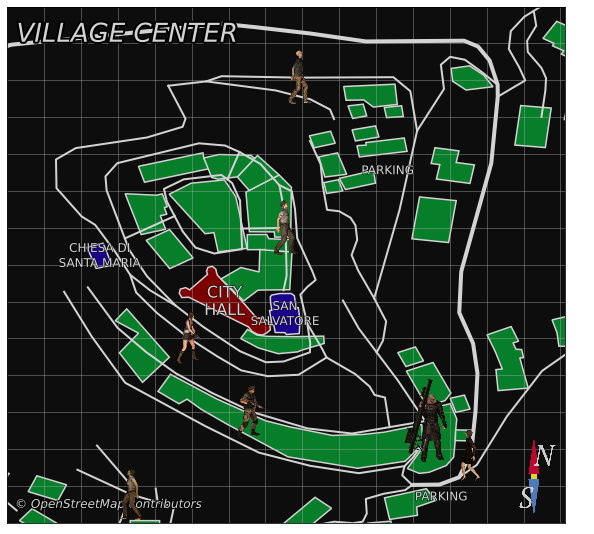

In [19]:
# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))

# Add Title
ax.text(lon_min+0.00065, lat_max-0.00015, 
                "VILLAGE CENTER", 
                fontsize=26,
                color="lightgrey",
                ha="center", 
                va="center", 
                fontstyle="italic",
                path_effects=[pe.withStroke(linewidth=4, 
                                            foreground="black")])
# Add OSM copyrights
ax.text(lon_min+0.00055, lat_min+0.00010, 
                "© OpenStreetMap contributors", 
                fontsize=12,
                color="lightgrey",
                ha="center", 
                va="center", 
                fontstyle="italic",
                path_effects=[pe.withStroke(linewidth=2, 
                                            foreground="black")])

# Add North arrow to map
na_image = Image.open(north_arrow)
na_imbox = OffsetImage(na_image, zoom=0.18)
na_annot = AnnotationBbox(na_imbox, 
                          (lon_max-0.00015, lat_min+0.00025), 
                          xybox=(0., 0.),
                          xycoords='data',
                          boxcoords='offset points',
                          frameon=False)
ax.add_artist(na_annot)

# Add Characters to map
for charact in characters:
    while(True):
        # Calculate the image position
        rand_high = random.choice(highway)["geometry"]
        cx, cy = rand_high[random.randint(0, len(rand_high) - 1)]
        if (lon_min + 0.00015 < cx < lon_max - 0.00015) \
        and (lat_min + 0.00015 < cy < lat_max - 0.00015):
            break
    charact_image = Image.open(charact)
    
    # Flip image
    if random.randint(0, 1):
        charact_image = ImageOps.mirror(charact_image)
    charact_imbox = OffsetImage(charact_image, zoom=0.20)
    charact_annot = AnnotationBbox(charact_imbox, 
                        (cx, cy), 
                        xybox=(0.0, 0.0),
                        xycoords='data', 
                        boxcoords='offset points',
                        frameon=False )
    ax.add_artist(charact_annot)

# Add parkings to map
for k, data in parkings.items():
    geom = data["geometry"]
    ax.text(geom[0], 
            geom[1], 
            "PARKING", 
            fontsize=12,
            color="lightgrey",
            ha="center", 
            va="center", 
            wrap=True, 
            path_effects=[pe.withStroke(linewidth=1, 
                                        foreground="black")])
# Add the buildings
for k, data in buildings.items():
    geom = data["geometry"]
    geom_poly = Polygon(geom)
    geom_center = geom_poly.centroid
    name = data["name"]
    if name:
        name_chars = name.upper().split()
        if len(name_chars) > 2:
            name_wrap = "\n".join([" ".join(t) for t in list(zip(*[iter(name_chars)] * 2))])
        else:
            name_wrap = "\n".join(name_chars)
    if data["type"] == "castle":
        ax.text(geom_center.x, 
                geom_center.y, 
                name_wrap,
                fontsize=16,
                color="lightgrey",
                ha="center", 
                va="center", 
                wrap=True, 
                path_effects=[pe.withStroke(linewidth=1, 
                                            foreground="black")])
        building_patch = MPoly(geom,
                               facecolor = (125/255, 0.0, 0.0),
                               edgecolor = "lightgrey",
                               lw="1.5")
    elif data["type"] == "church":
        ax.text(geom_center.x, 
                geom_center.y, 
                name_wrap, 
                color="lightgrey",
                fontsize=12,
                ha="center", 
                va="center", 
                wrap=True,
                path_effects=[pe.withStroke(linewidth=1, 
                                            foreground="black")])
        
        building_patch = MPoly(geom, 
                               facecolor = (27/255, 0.0, 142/255), 
                               edgecolor = "lightgrey", 
                               lw="1.5")
    else:
        building_patch = MPoly(geom, 
                               facecolor = (6/255, 126/255, 42/255), 
                               edgecolor = "lightgrey", 
                               lw="1.5")
    ax.add_patch(building_patch)
    
# Add roads to map
for k, data in highway.items():
    geom = data["geometry"]
    if data["type"] == "secondary":   
        ax.plot(geom[:, 0], geom[:, 1], color="lightgrey", lw=4)
    elif data["type"] in ("path", "track"):
        ax.plot(geom[:, 0], geom[:, 1], color="lightgrey", linestyle="dashed", lw=2)
    else:
        ax.plot(geom[:, 0], geom[:, 1], color="lightgrey", lw=2)

# Set map limits
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

# Set the grid
major_ticks_x = np.arange(lon_min, lon_max, 0.00020)
major_ticks_y = np.arange(lat_min, lat_max, 0.00020)
ax.set_xticks(major_ticks_x)
ax.set_yticks(major_ticks_y)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)

# Remove xticks and xticks labels
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

# Set the figure background color
ax.set_facecolor((0.05, 0.05, 0.05))
ax.set_aspect('equal')

# Save the figure
fig.savefig("05_OSM.png", dpi=300, bbox_inches='tight')